# **Stock Price Prediction Using LSTM**

### Importing Libraries


In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random as python_random
from tensorflow.keras.layers import Input
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import plotly.express as px

In [2]:
# Fix random seed for reproducibility
np.random.seed(1)
python_random.seed(1)
tf.random.set_seed(1)

### Data Collection


In [3]:
# Download the historical stock price data for Apple
hist_data = yf.download('AAPL','2015-01-02','2019-12-31')
hist_data.index = pd.to_datetime(hist_data.index)
hist_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687300,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689539,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021715,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,237458000
...,...,...,...,...,...,...
2019-12-23,70.132500,71.062500,70.092499,71.000000,68.908997,98572000
2019-12-24,71.172501,71.222504,70.730003,71.067497,68.974503,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.342979,93121200


### Data Preprocessing

In [4]:
# Checking for missing values
print(hist_data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [5]:
# Filling missing dates
date_range = pd.date_range(start='2015-01-02', end='2019-12-30', freq='D')
hist_data = hist_data.reindex(date_range)
hist_data= hist_data.interpolate(method='linear')
hist_data.dropna()
hist_data.head(15)

,Open,High,Low,Close,Adj Close,Volume
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,2.128184e+08
2015-01-03,27.589167,27.627501,26.675833,27.075834,24.145074,2.275929e+08
2015-01-04,27.330833,27.395000,26.514167,26.819167,23.916187,2.423675e+08
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687300,2.571420e+08
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689539,2.631884e+08
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021715,1.604236e+08
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,2.374580e+08
2015-01-09,28.167500,28.312500,27.552500,28.002501,24.971441,2.147980e+08
2015-01-10,28.161666,28.260833,27.435000,27.772500,24.766336,2.093997e+08
2015-01-11,28.155833,28.209166,27.317500,27.542500,24.561232,2.040015e+08


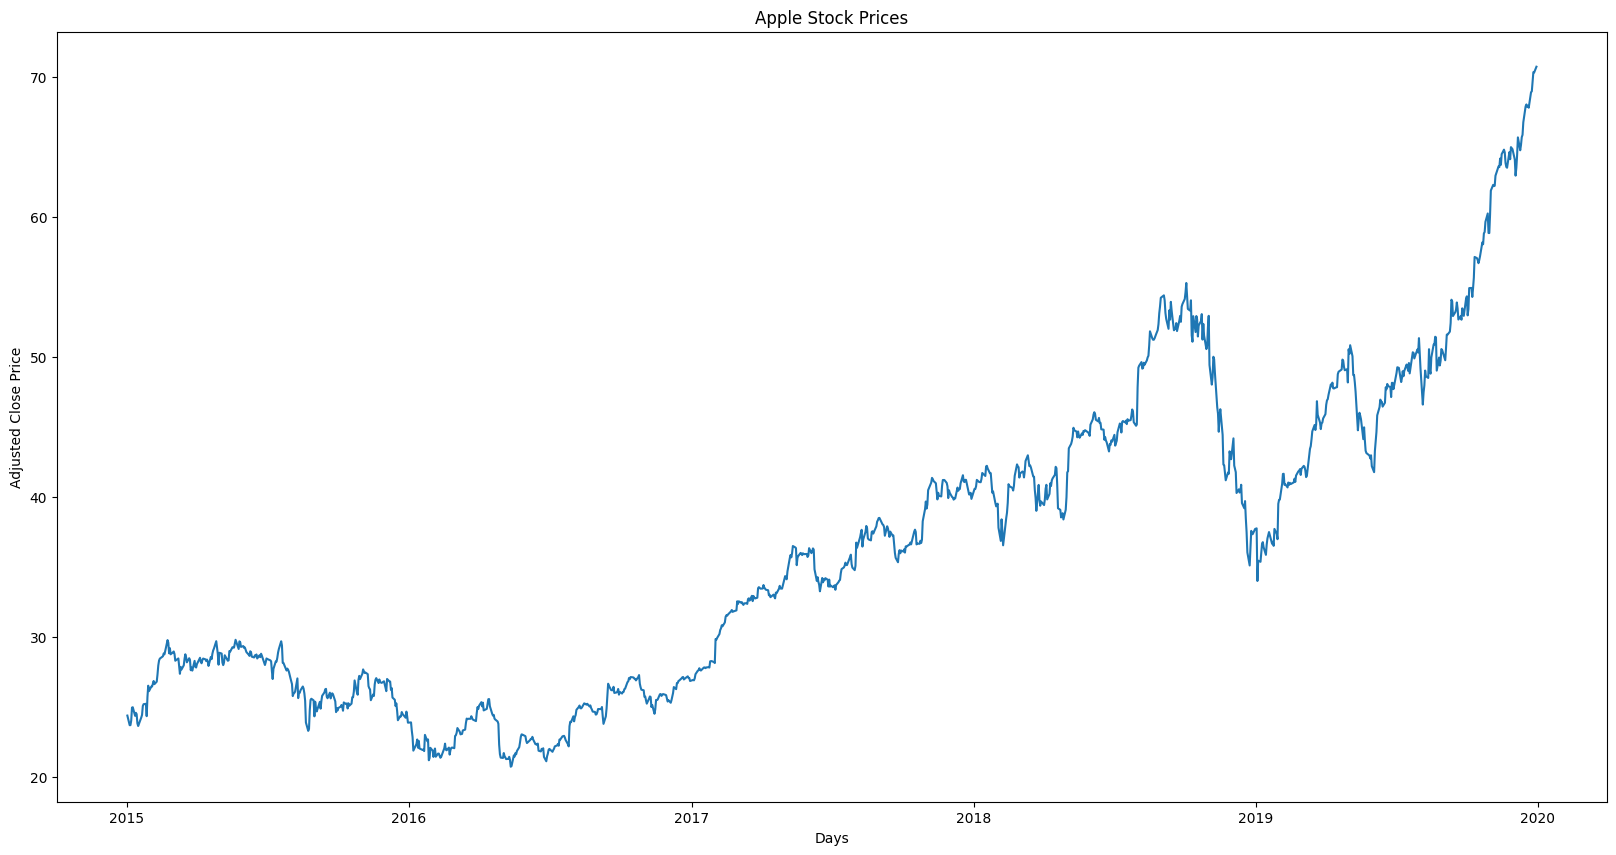

In [6]:
# Plot historical stock data
plt.figure(figsize=(20, 10))
plt.xlabel('Days')
plt.ylabel('Adjusted Close Price')
plt.title('Apple Stock Prices')
plt.plot(hist_data['Adj Close'])
plt.show()

### Splitting data


In [7]:
hist_data_length = len(hist_data)
train_split_ratio = 0.7
valid_split_ratio = 0.85
train_data_length = round(hist_data_length * train_split_ratio)
valid_data_length = round(hist_data_length * valid_split_ratio)

In [8]:
train_hist_data_close_values = hist_data[:train_data_length].iloc[:,4:5]
valid_hist_data_close_values = hist_data[train_data_length:valid_data_length].iloc[:,4:5]
test_hist_data_close_values = hist_data[valid_data_length:].iloc[:,4:5]

### Normalising data

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
train_hist_data_close_scaled = scaler.fit_transform(train_hist_data_close_values)
valid_hist_data_close_scaled = scaler.transform(valid_hist_data_close_values)
test_hist_data_close_scaled = scaler.transform(test_hist_data_close_values)

### Sequence Creation

In [10]:
def create_sequence(data, time_step):
    X, Y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i,0])
        Y.append(data[i,0])
    return np.array(X), np.array(Y)

In [11]:
time_step = 50
X_train, Y_train = create_sequence(train_hist_data_close_scaled,time_step)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
Y_train = np.reshape(Y_train, (Y_train.shape[0],1))

In [12]:
X_valid, Y_valid = create_sequence(valid_hist_data_close_scaled,time_step)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1],1))
Y_valid = np.reshape(Y_valid, (Y_valid.shape[0],1))

In [13]:
X_test, Y_test = create_sequence(test_hist_data_close_scaled,time_step)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
Y_test = np.reshape(Y_test, (Y_test.shape[0],1))

### Building the LSTM Model

In [14]:
model_lstm = Sequential()
model_lstm.add(Input(shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(200, return_sequences= True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(200, return_sequences= False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam")
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 200)                 │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 482,601 (1.84 MB)

 Trainable params: 482,601 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
history_lstm = model_lstm.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs = 200, batch_size = 32, callbacks =[early_stopping])

Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0395 - val_loss: 0.0064
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 9/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 10/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 11/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 12/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo

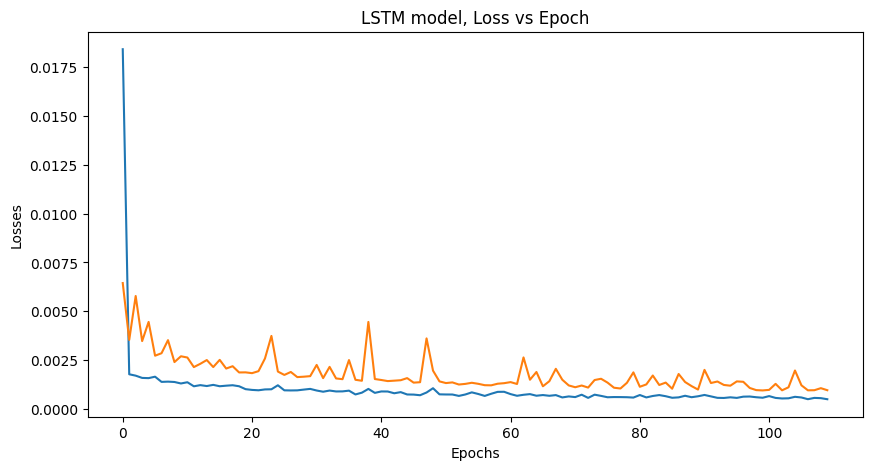

In [16]:
# Plot Loss vs Epoch
plt.figure(figsize =(10,5))
plt.plot(history_lstm.history["loss"], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

### Model Prediction

In [17]:
Y_pred_train = model_lstm.predict(X_train)
Y_pred_valid = model_lstm.predict(X_valid)
Y_test_pred_lstm = model_lstm.predict(X_test)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [18]:
# Scaling back to original value
Y_pred_train= scaler.inverse_transform(Y_pred_train)
Y_pred_valid= scaler.inverse_transform(Y_pred_valid)
Y_test_pred_lstm = scaler.inverse_transform(Y_test_pred_lstm)
Y_train = scaler.inverse_transform(Y_train)
Y_valid = scaler.inverse_transform(Y_valid)
Y_test = scaler.inverse_transform(Y_test)

### Residual Analysis

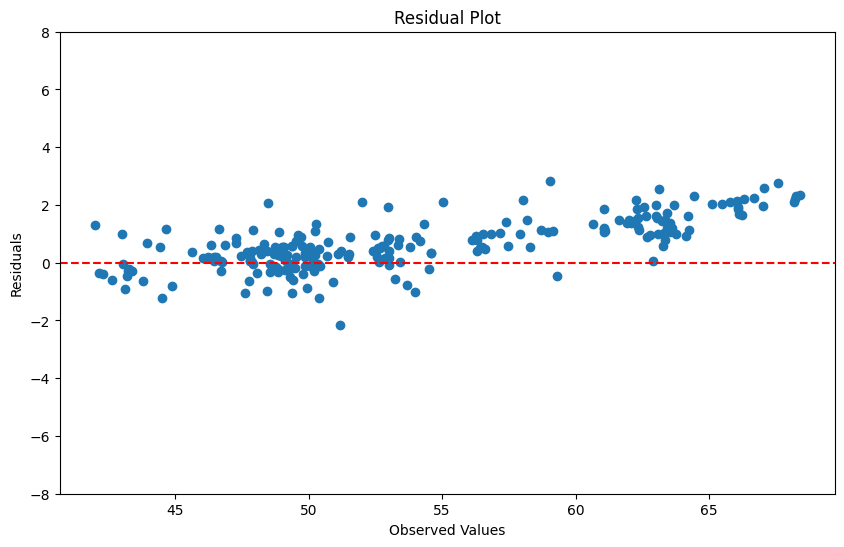

In [19]:
# Calculate residuals
residuals = Y_test - Y_test_pred_lstm
# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(Y_test_pred_lstm, residuals)
plt.title('Residual Plot')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim([-8, 8])
plt.show()

### Error Metrics Calculations

In [20]:
# Metrics for LSTM Model
mse_lstm_train = round(mean_squared_error(Y_train, Y_pred_train),2)
mae_lstm_train = round(mean_absolute_error(Y_train, Y_pred_train),2)
mape_lstm_train = round((mean_absolute_percentage_error(Y_train, Y_pred_train)*100),2)
r2_lstm_train = round((r2_score(Y_train, Y_pred_train)*100),2)

mse_lstm_valid= round(mean_squared_error(Y_valid, Y_pred_valid),2)
mae_lstm_valid = round(mean_absolute_error(Y_valid, Y_pred_valid),2)
mape_lstm_valid = round((mean_absolute_percentage_error(Y_valid, Y_pred_valid)*100),2)
r2_lstm_valid = round((r2_score(Y_valid, Y_pred_valid)*100),2)

mse_lstm_test = round(mean_squared_error(Y_test, Y_test_pred_lstm),2)
mae_lstm_test = round(mean_absolute_error(Y_test, Y_test_pred_lstm),2)
mape_lstm_test = round((mean_absolute_percentage_error(Y_test, Y_test_pred_lstm)*100),2)
r2_lstm_test = round((r2_score(Y_test, Y_test_pred_lstm)*100),2)

# Printing Results
print("\nLSTM Model Training Metrics:")
print("MSE:", mse_lstm_train, "MAE:", mae_lstm_train, "MAPE:", mape_lstm_train, "Accuracy(R2 Score):", r2_lstm_train)
print("\nLSTM Model Validation Metrics:")
print("MSE:", mse_lstm_valid, "MAE:", mae_lstm_valid, "MAPE:", mape_lstm_valid, "Accuracy(R2 Score):", r2_lstm_valid)
print("\nLSTM Model Testing Metrics:")
print("MSE:", mse_lstm_test, "MAE:", mae_lstm_test, "MAPE:", mape_lstm_test, "Accuracy(R2 Score):", r2_lstm_test)


LSTM Model Training Metrics:
MSE: 0.14 MAE: 0.25 MAPE: 0.85 Accuracy(R2 Score): 99.7

LSTM Model Validation Metrics:
MSE: 0.6 MAE: 0.55 MAPE: 1.23 Accuracy(R2 Score): 98.41

LSTM Model Testing Metrics:
MSE: 1.17 MAE: 0.85 MAPE: 1.48 Accuracy(R2 Score): 98.0


In [21]:
# Plot the bar chart for errors
data = {
    'Phase': ['Training', 'Validation', 'Testing'],
    'MSE': [mse_lstm_train, mse_lstm_valid, mse_lstm_test],
    'MAE': [mae_lstm_train, mae_lstm_valid, mae_lstm_test],
    'MAPE': [mape_lstm_train, mape_lstm_valid, mape_lstm_test],
}
df = pd.DataFrame(data)
df_long = pd.melt(df, id_vars='Phase', var_name='Metric', value_name='Value')
fig = px.bar(
    data_frame=df_long,
    x='Metric',
    y='Value',
    color='Phase',
    barmode='group',
    title='LSTM Model: Error Metrics Across Phases',
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig.update_layout(
    xaxis_title='Metric',
    yaxis_title='Value',
    legend_title='Phase',
    yaxis=dict(showgrid=True)
)
fig.show()

### Visualisation

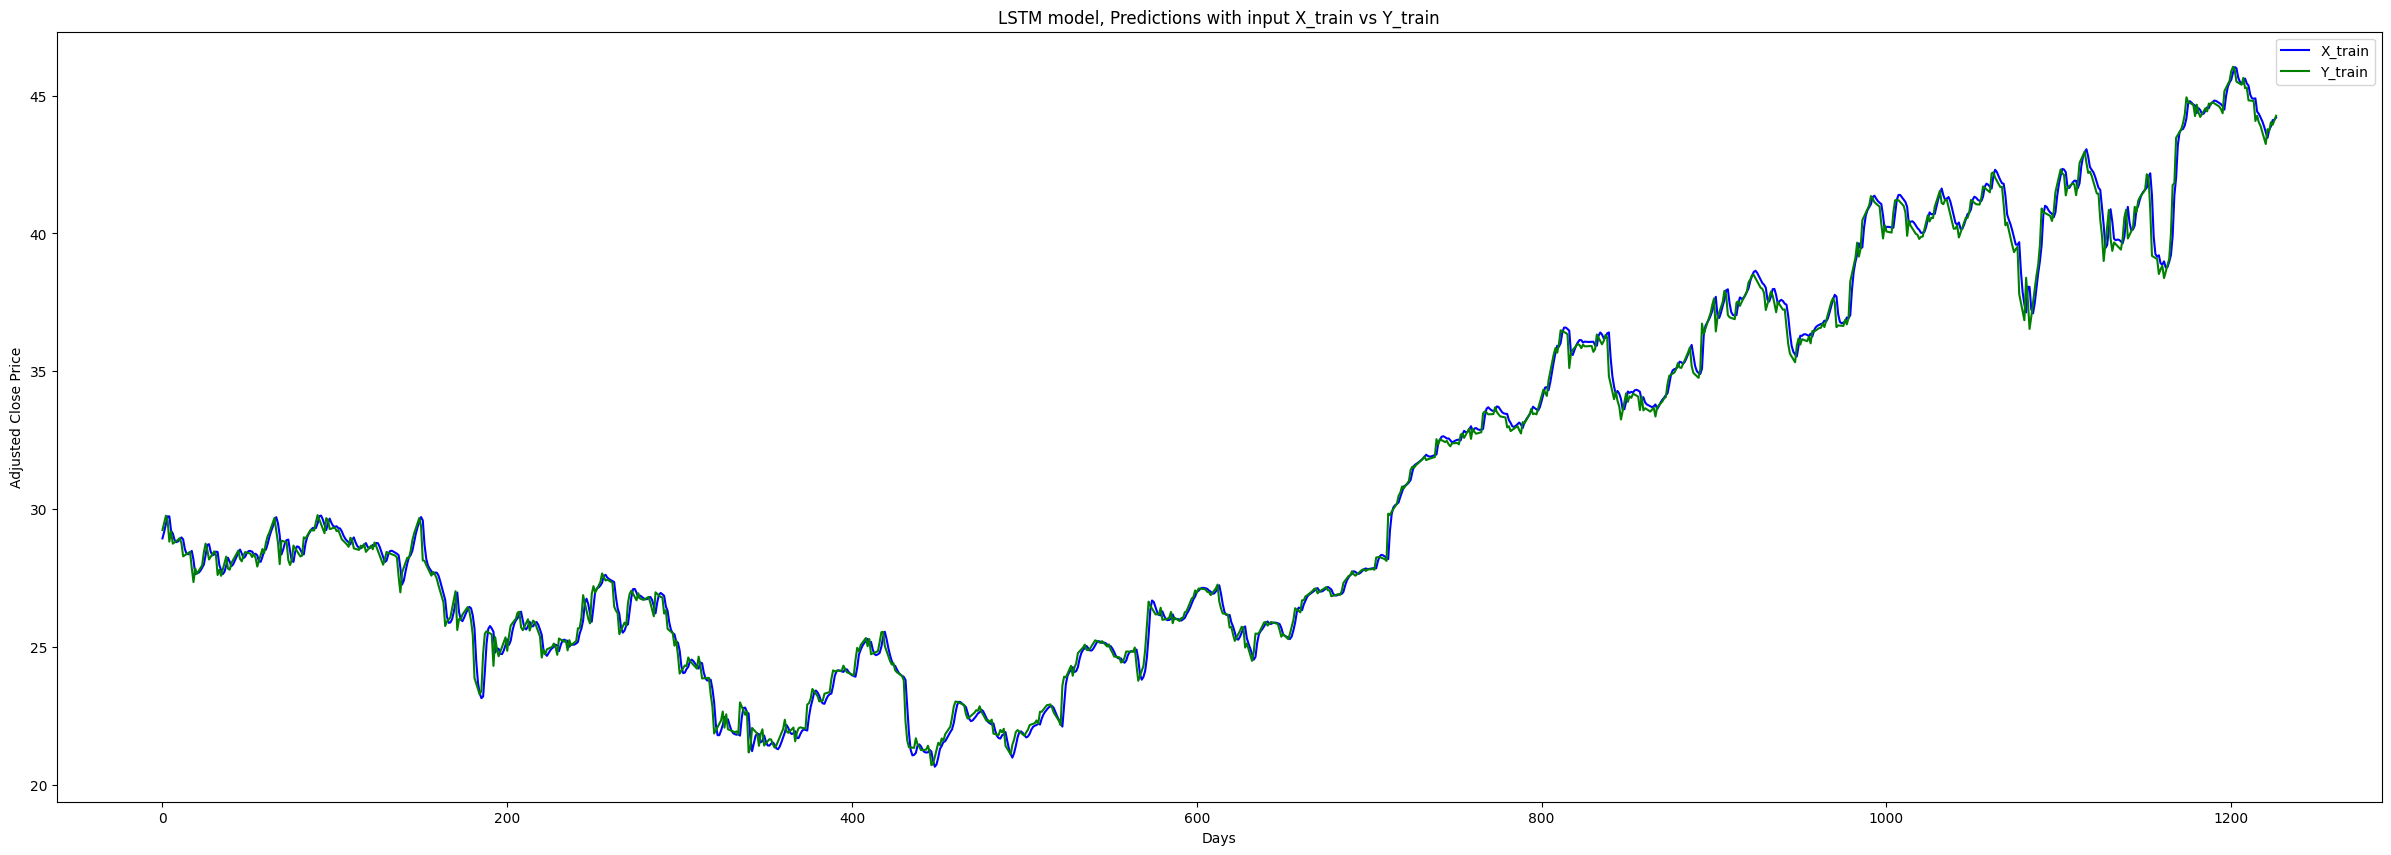

In [22]:
# Visualising training dataset
plt.figure(figsize = (30,10))
plt.plot(Y_pred_train, color = "b", label = "X_train" )
plt.plot(Y_train, color = "g", label = "Y_train")
plt.xlabel("Days")
plt.ylabel("Adjusted Close Price")
plt.title("LSTM model, Predictions with input X_train vs Y_train")
plt.legend()
plt.show()

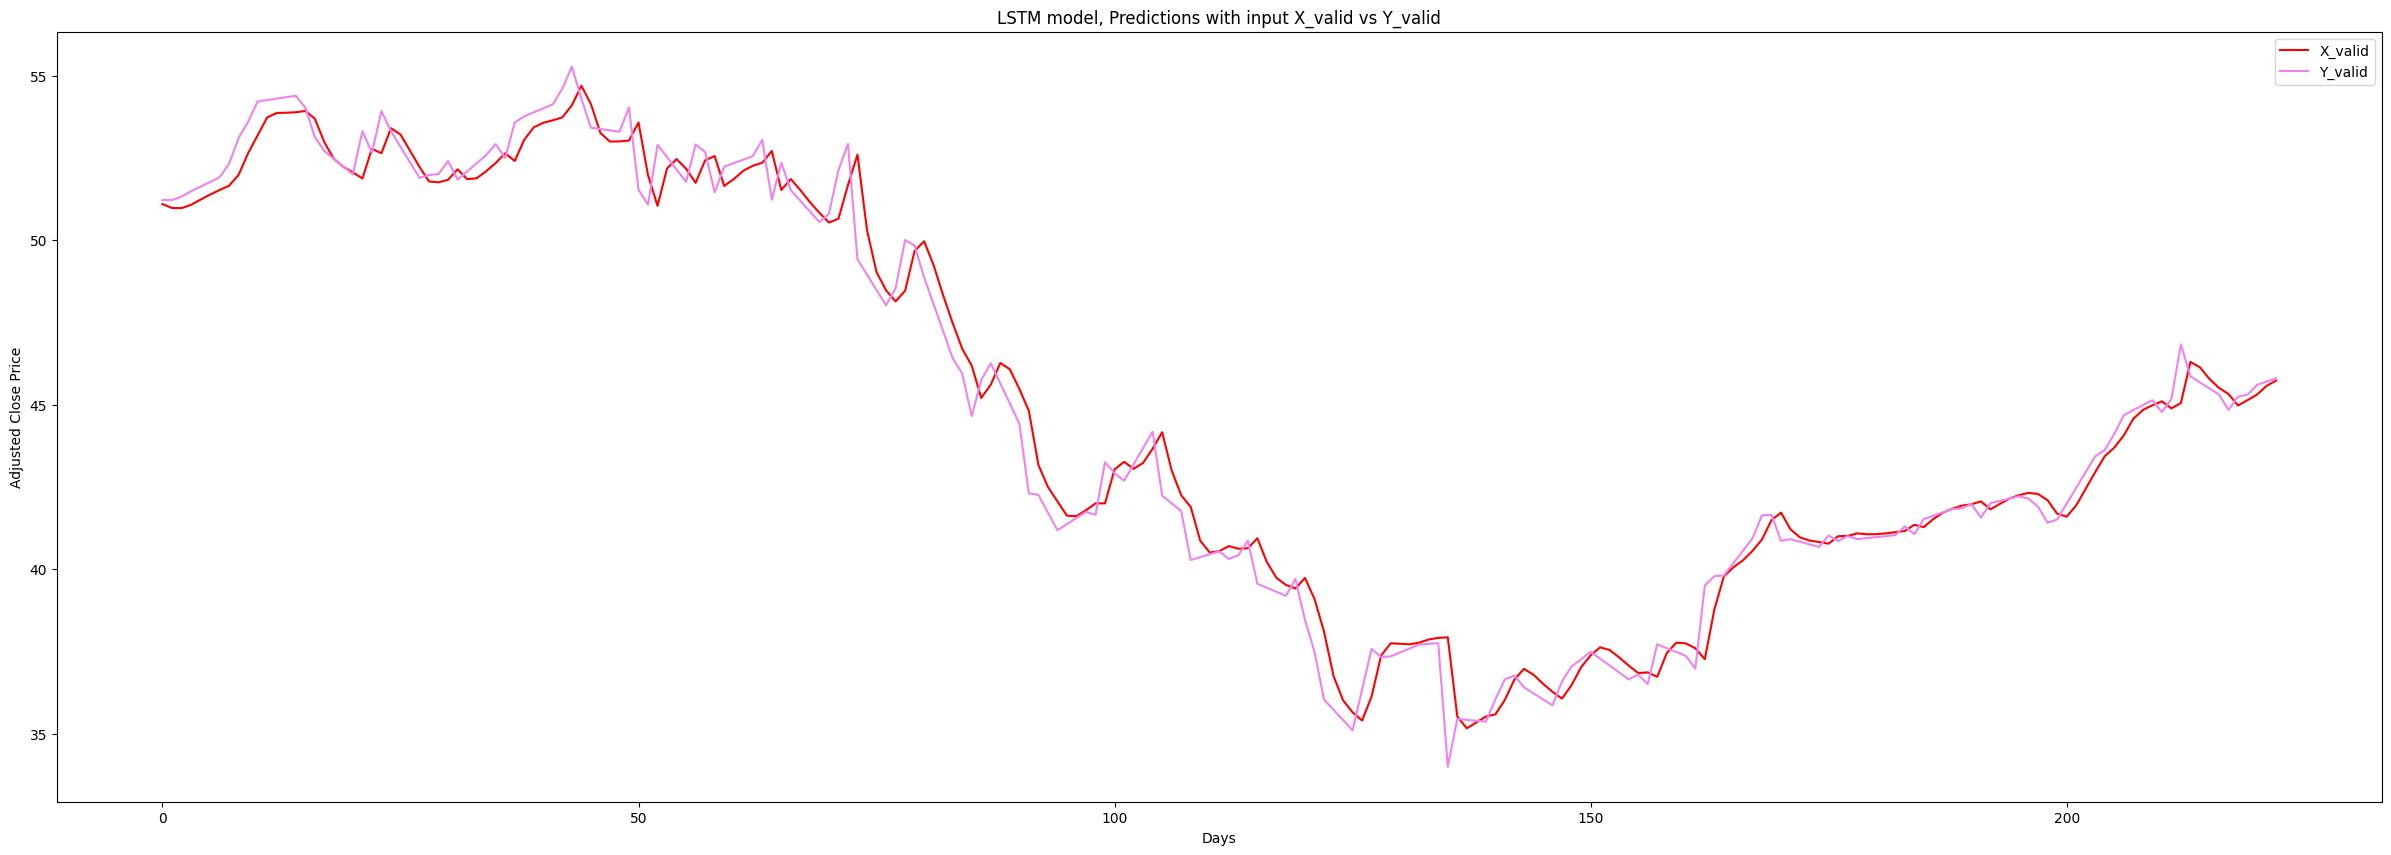

In [23]:
# Visualising validation dataset
plt.figure(figsize = (30,10))
plt.plot(Y_pred_valid, color = "red", label = "X_valid" )
plt.plot(Y_valid, color = "violet", label = "Y_valid")
plt.xlabel("Days")
plt.ylabel("Adjusted Close Price")
plt.title("LSTM model, Predictions with input X_valid vs Y_valid")
plt.legend()
plt.show()

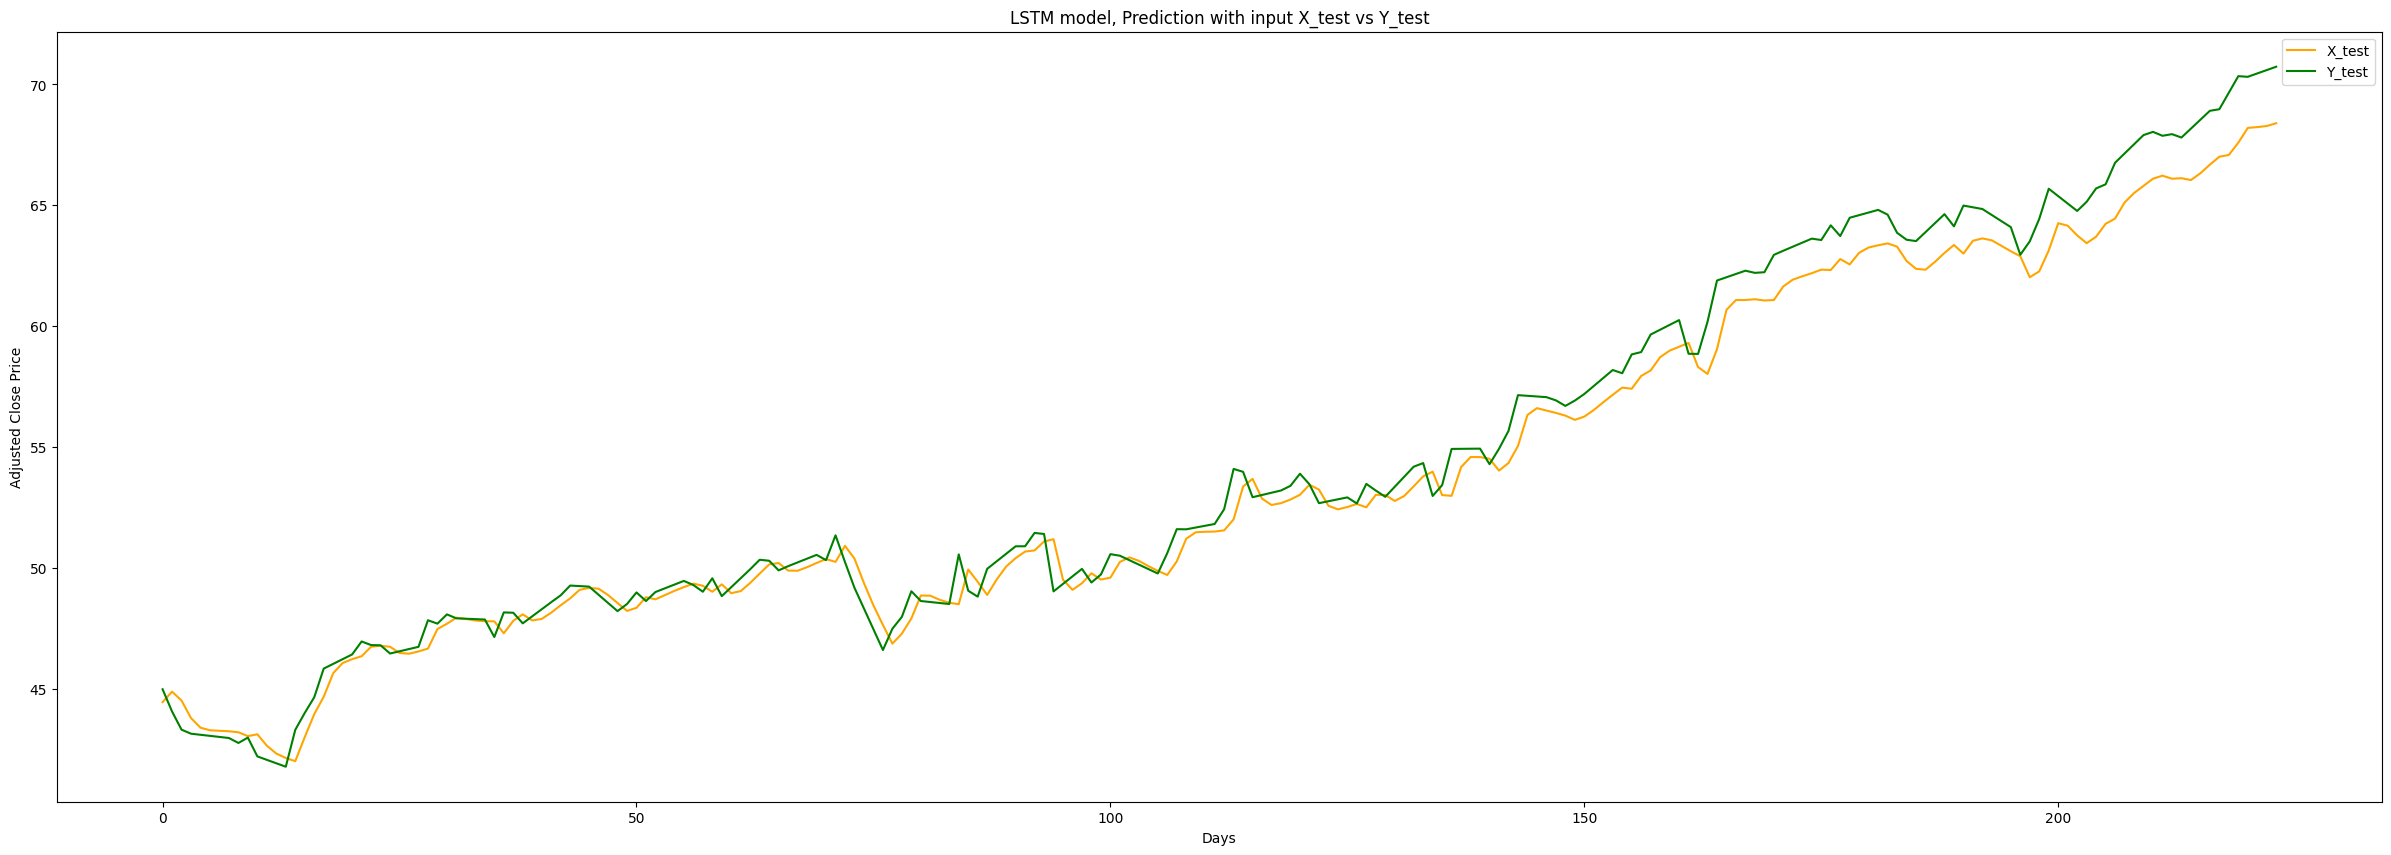

In [24]:
# Visualising testing dataset
plt.figure(figsize = (30,10))
plt.plot(Y_test_pred_lstm, label = "X_test", c = "orange")
plt.plot(Y_test, label = "Y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Adjusted Close Price")
plt.title("LSTM model, Prediction with input X_test vs Y_test")
plt.legend()
plt.show()

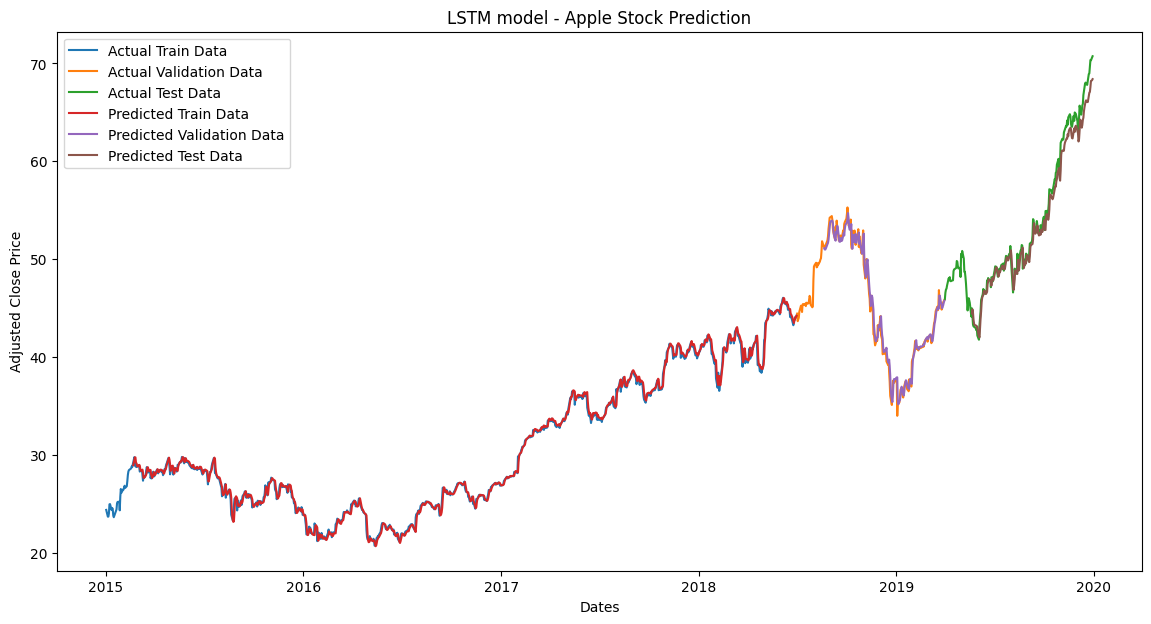

In [25]:
# Visualisation for Apple stock prediction
plt.subplots(figsize =(14,7))
plt.plot(train_hist_data_close_values.index ,train_hist_data_close_values, label = "Actual Train Data")
plt.plot(valid_hist_data_close_values.index ,valid_hist_data_close_values, label = "Actual Validation Data")
plt.plot(test_hist_data_close_values.index, test_hist_data_close_values, label = "Actual Test Data")
plt.plot(train_hist_data_close_values.index[time_step:], Y_pred_train, label = "Predicted Train Data")
plt.plot(valid_hist_data_close_values.index[time_step:], Y_pred_valid, label = "Predicted Validation Data")
plt.plot(test_hist_data_close_values.index[time_step:], Y_test_pred_lstm, label = "Predicted Test Data")
plt.xlabel("Dates")
plt.ylabel("Adjusted Close Price")
plt.title("LSTM model - Apple Stock Prediction")
plt.legend()
plt.show()